## Sources and Inspiration:


https://towardsdatascience.com/variational-autoencoders-vaes-for-dummies-step-by-step-tutorial-69e6d1c9d8e9
https://colab.research.google.com/github/lschmiddey/fastpages_/blob/master/_notebooks/2021-03-14-tabular-data-variational-autoencoder.ipynb#scrollTo=ZG91fCG40vWz 

https://github.com/lschmiddey/fastpages_/blob/master/_notebooks/2021-03-14-tabular-data-variational-autoencoder.ipynb 

https://github.com/lschmiddey

https://gitlab.com/m4gpie/self-supervised-ecoacoustics/-/blob/main/code/ecoacoustics/models/encoder.py 

https://github.com/geyang/variational_autoencoder_pytorch/blob/master/model.py 

Reference: 'lschmiddey' GitHub 

# To-Do's

- make the diagnosis the label in the dataset!
- maybe include the patient id in the label?

## Setup and Prerequisites 

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb #working with and logging into the weights and biases tools from 'wandb.ai'
wandb.login()

wandb: Currently logged in as: mae28. Use `wandb login --relogin` to force relogin


True

In [ ]:
#Import Statements 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from numpy import asarray
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchsummary import summary
from torch.nn.modules.activation import LeakyReLU
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.activation import ReLU

In [ ]:
#Connecting to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
#Connecting to Google Drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Navigating to 
root_path = 'drive/MyDrive/ColabNotebooks/JRA' 

import os
os.chdir('/content/drive/MyDrive/ColabNotebooks/Final-Year-Project')
!ls

ADNI_002_S_0295_MR_Hippocampal_Mask_Hi_20080228111448800_S13408_I93328.nii
ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070319113623975_S13408_I45108.nii
aparcaseg.nii
aparcaseg.nrrd
aparcaseg.seg.nrrd
average305_t1_tal_lin.nii
Data_Processing_24.02.23.ipynb
dice_scores_list_FS_reg_MAPER.csv
dice_scores_list_FS_reg_Snt.csv
dice_scores_list_MAPER_reg_FS.csv
dice_scores_list_Maper_reg_Snt1.csv
dice_scores_list_Maper_reg_Snt.csv
dice_scores_list_SNT_reg_FS.csv
dice_scores_list_SNT_reg_MAPER.csv
FreeSurfer_Cross-Sectional_Processing_aparc+aseg
FS_Extra_Original
FS_Extra_Original_Wrong
FS_Follow_New
FS_Nii_Follow_Up
FS_Segmentations
FYP_VAE_Model.ipynb
Hippocampal_Masks.ipynb
hippocampal_volume_all_with_diagnosis.csv
Hippocampal_Volumes_ADNI_compressed.csv
Hippocampal_Volumes_ADNI.csv
id_and_diagnosis.csv
jaccard_scores_list_FS_reg_MAPER.csv
jaccard_scores_list_FS_reg_Snt.csv
jaccard_scores_list_MAPER_reg_FS.csv
jaccard_scores_list_Maper_reg_Snt1.csv
jaccard_scores_list_

# Functions and Theory:
## Data Preprocessing

In [ ]:
def load_and_standardize_data(df):

    # replace nan with mean 
    df = df.reshape(-1, df.shape[1]).astype('float32')

    # randomly split
    X_train, X_test = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)

    # standardize values
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)   
    return X_train, X_test, scaler

In [ ]:
# a function to use ordinal encoding for the columsn in the data that have continous categorical data following a natural order, this order can be specified if known but needs [] around it as originally the OrdinalEncoder function expects a list of columns 
def ordinal_encod(df_row, ordered_catg='auto'): 

  data_row = asarray(df_row)
  data_row = data_row.reshape(-1, 1)

  # define and transform data with ordinal encoding
  encoder_ordinal = OrdinalEncoder(categories=ordered_catg) # 
  encoder_ordinal.fit(data_row)

  ord_enc_row = encoder_ordinal.transform(data_row)

  return ord_enc_row

In [ ]:
# function to build rtain and test datasets for a given batch size using the DataBuilder Class below
def test_train_datasets(df, batch_size): 

  traindata_set = DataBuilder(df, train=True) 
  testdata_set = DataBuilder(df, train=False)

  trainloader = DataLoader(dataset=traindata_set,batch_size= batch_size, drop_last=True) # drop the last element if the batch only consists of one element
  testloader= DataLoader(dataset=testdata_set,batch_size= batch_size, drop_last=True) 

  print('Data Shape:', trainloader.dataset.x.shape, testloader.dataset.x.shape)
  return trainloader, testloader

In [ ]:
# Class to standardize, pre-process and build the train and test datasets for the VAE training
class DataBuilder(Dataset):
    def __init__(self, df, train=True):
        self.X_train, self.X_test, self.standardizer  = load_and_standardize_data(df)
        if train:
            self.x = torch.from_numpy(self.X_train)
            self.len=self.x.shape[0]
        else:
            self.x = torch.from_numpy(self.X_test)
            self.len=self.x.shape[0]
        del self.X_train
        del self.X_test 
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

## VAE Model 

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H,H2,latent_dim, activation=ReLU(), inbetween_layer=nn.BatchNorm1d):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_additional1 = inbetween_layer(num_features=H)
        self.linear2=nn.Linear(H,H2) # adda relu layer for non-linearity
        self.lin_additional2 = inbetween_layer(num_features=H2)
        
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, H2)
        self.fc_additional1 =inbetween_layer(num_features=H2)
        self.fc21 = nn.Linear(H2, latent_dim) #the output layer for the mean vector of the size of the latent dimension
        self.fc22 = nn.Linear(H2, latent_dim) #the output layer for the mean vector of the size of the latent dimension

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_additional3 = inbetween_layer(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_additional4 = inbetween_layer(H2)
        
        # Decoder
        self.linear4=nn.Linear(H2,H)
        self.lin_additional4 = inbetween_layer(num_features=H)

        self.linear5=nn.Linear(H,D_in)
        self.linear51=nn.Linear(H,D_in, bias=True) # the output vector of this layer will be the size of the input features to get the predicted mean
        # model.linear51[0].bias.data = my_biases -> customizing the biases for this layer in order to penalize large variances 

        
        # Activation Function
        self.activation = activation  #change this to self.activation and add an additional parameter to the AutoEncoder class which represents the type of activation function that should be tested out
        

    def encode(self, x):
        lin1 = self.activation(self.lin_additional1(self.linear1(x)))
        lin2 = self.activation(self.lin_additional2(self.linear2(lin1)))

        fc1 = self.activation(self.fc_additional1(self.fc1(lin2)))

        z_mu = self.fc21(self.activation(fc1))
        z_logvar = self.fc22(self.activation(fc1)) 
        
        return z_mu, z_logvar
    
    def reparameterize(self, z_mu, z_logvar):                          
        std = z_logvar.mul(0.5).exp_()
        eps = torch.distributions.Normal(z_mu, std).rsample()
        return eps.mul(std).add_(z_mu) #returns the latent vector z sampled from the mean and variance 

        
    def decode(self, z):
        fc3 = self.activation(self.fc_additional3(self.fc3(z)))
        fc4 = self.activation(self.fc_additional4(self.fc4(fc3)))

        lin4 = self.activation(self.lin_additional4(self.linear4(fc4)))

        #outputs
        x_recon = self.linear5(self.activation(lin4)) #this variable is the mean of the reconstruction 
        x_recon_log_var = self.linear51(self.activation(lin4))

        return x_recon, x_recon_log_var


    def forward(self, x): 
        z_mu, z_logvar = self.encode(x)
        z = self.reparameterize(z_mu, z_logvar)
        x_recon, x_recon_logvar = self.decode(z)

        return x_recon, z_mu, z_logvar, x_recon_logvar


    def forward_mean_only(self, x): 
        z_mu, z_logvar = self.encode(x)
        x_recon, x_recon_logvar = self.decode(z_mu)

        return x_recon, z_mu, z_logvar, x_recon_logvar

In [ ]:
model_architecture = Autoencoder(3, H=70, H2=12,latent_dim=1).to(device)
print(model_architecture)

Autoencoder(
  (linear1): Linear(in_features=3, out_features=70, bias=True)
  (lin_additional1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=70, out_features=12, bias=True)
  (lin_additional2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=12, out_features=12, bias=True)
  (fc_additional1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=12, out_features=1, bias=True)
  (fc22): Linear(in_features=12, out_features=1, bias=True)
  (fc3): Linear(in_features=1, out_features=1, bias=True)
  (fc_additional3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1, out_features=12, bias=True)
  (fc_additional4): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=12, out_features=70, bias=True

Custom Loss Classes using MSE and or Individual Variances:

In [ ]:
class customLoss(nn.Module): 
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [ ]:
from torch.nn.modules.loss import GaussianNLLLoss
#Inferring an individual variance for each feature - represent how confident the model is in predicting a given feature

class customLoss_individual(nn.Module): 
    def __init__(self):
        super(customLoss_individual, self).__init__()
        self.log_prob_Gaus_loss = nn.GaussianNLLLoss(reduction='none')
    
    
    def forward(self, x_recon, x, z_mu, z_logvar, x_recon_logvar, KL_weight): 
        loss_log_prob_sum = torch.sum(self.log_prob_Gaus_loss(x_recon, x, torch.exp(x_recon_logvar)), axis=1) #take the sum over the observations -> sum up the 37 values to get a value for each sample in the batch of size 500
        loss_log_prob = loss_log_prob_sum.mean(axis=0) #take the batch-wise mean 

        loss_KLD_sum =  -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp(), axis=1)
        loss_KLD = loss_KLD_sum.mean(axis=0) #after summing the KL terms for each of the latent space variables it takes the batch-wise mean

        return loss_log_prob, (KL_weight * loss_KLD)

In [ ]:
class customLoss_Gaussian_NLLL(nn.Module): 
    def __init__(self):
        super(customLoss_Gaussian_NLLL, self).__init__()
        self.log_prob_Gaus_loss = nn.GaussianNLLLoss(reduction='none') 
    
    def forward(self, x_recon, x, z_mu, z_logvar, x_recon_logvar): 
        loss_log_prob_sum = torch.sum(self.log_prob_Gaus_loss(x_recon, x, torch.exp(x_recon_logvar)), axis=-1) #take the sum over the observations -> sum up the 37 values to get a value for each sample in the batch of size 500
        loss_log_prob = loss_log_prob_sum.mean(axis=0) #take the batch-wise mean - mean over the rows 

        return loss_log_prob  

In [ ]:
class customLoss_KL_divergence(nn.Module): 
    def __init__(self):
        super(customLoss_KL_divergence, self).__init__()
    
    def forward(self, x_recon, x, z_mu, z_logvar, x_recon_logvar): 
        loss_KLD_sum =  -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp(), axis=1) #taking the sum over the latent dimensions
        loss_KLD = loss_KLD_sum.mean(axis=0) #after summing the KL terms taking the batch-wise mean

        return loss_KLD

## Training VAE Model

In [ ]:
def train2(epoch, trainloader, model, optimizer, customized_loss, train_losses, return_loss=False):
    model.train()
    train_loss = 0


    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad() # Sets the gradients of all optimized torch.Tensor s to zero
        recon_batch, mu, logvar = model(data)
        loss = customized_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        

    if epoch % 200 == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        
        train_losses.append(train_loss / len(trainloader.dataset))

    if return_loss==True :
      return train_loss / len(trainloader.dataset)

In [ ]:
def train(epoch, trainloader, model, optimizer, customized_loss, train_losses, return_loss=False, KL_weight=0.01):
    model.train()
    train_loss = 0
    train_loss_Gaussian = 0
    train_loss_KL = 0


    for batch_idx, data in enumerate(trainloader): #tqdm(enumerate(trainloader), total=len(trainloader), leave=False):
        data = data.to(device)
        optimizer.zero_grad() # Sets the gradients of all optimized torch.Tensor s to zero
        x_recon, z_mu, z_logvar, x_recon_logvar = model(data)
        Gaussian_loss, KL_loss = customized_loss(x_recon, data, z_mu, z_logvar, x_recon_logvar, KL_weight)
        loss = Gaussian_loss + KL_loss
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        #additional information about the invidiual losses - reconstruction loss and prior 
        train_loss_Gaussian += Gaussian_loss.item()
        train_loss_KL += KL_loss.item()

    if epoch % 50 == 0:        
        print('====> Epoch: {}    Average training loss: {:.4f}   Gaussian training loss: {:.4f}    KL training divergence: {:.4f} '.format(
            epoch, train_loss / len(trainloader.dataset), train_loss_Gaussian / len(trainloader.dataset), train_loss_KL / len(trainloader.dataset)))
        
    train_losses.append(train_loss / len(trainloader.dataset))

    if return_loss==True :
      return train_loss / len(trainloader.dataset)

In [ ]:
def test2(epoch, testloader, model, optimizer, customized_loss, test_losses, return_loss=False):

    with torch.no_grad(): #The wrapper with torch.no_grad() temporarily sets all of the requires_grad flags to false
        test_loss = 0

        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = customized_loss(recon_batch, data, mu, logvar)
            test_loss += loss.item()

            if epoch % 200 == 0:        
                print('====> Epoch: {} Average test loss: {:.4f}'.format(
                    epoch, test_loss / len(testloader.dataset)))
                
            test_losses.append(test_loss / len(testloader.dataset))

    if return_loss==True :
      return test_loss / len(testloader.dataset)

In [ ]:
def test(epoch, testloader, model, optimizer, customized_loss, test_losses, return_loss=False, KL_weight=0.01):

    with torch.no_grad(): #The wrapper with torch.no_grad() temporarily sets all of the requires_grad flags to false
        test_loss = 0
        test_loss_Gaussian = 0
        test_loss_KL = 0


        for batch_idx, data in enumerate(testloader): # tqdm(enumerate(testloader), total=len(testloader), leave=False)
            data = data.to(device)
            optimizer.zero_grad()
            x_recon, z_mu, z_logvar, x_recon_logvar  = model(data)
            Gaussian_loss, KL_loss = customized_loss(x_recon, data, z_mu, z_logvar, x_recon_logvar, KL_weight)
            loss = Gaussian_loss + KL_loss
            test_loss += loss.item()

            #additional information about the invidiual losses - reconstruction loss and prior 
            test_loss_Gaussian += Gaussian_loss.item()
            test_loss_KL += KL_loss.item()

            if epoch % 50 == 0:        
                print('====> Epoch: {}    Average test loss: {:.4f}       Gaussian test loss: {:.4f}       KL test divergence: {:.4f}'.format(
                    epoch, test_loss / len(testloader.dataset), test_loss_Gaussian / len(testloader.dataset), test_loss_KL / len(testloader.dataset) ))
                
            test_losses.append(test_loss / len(testloader.dataset))

    if return_loss==True :
      return test_loss / len(testloader.dataset)

# Practice and Experimentation:
### Working with the generated hippocampal volumes of SNT, FS and Maper segmentation 

Displaying Raw Data:

In [ ]:
#Displaying the 'raw' Biomarkers of the 1000 selected patients
df_hippo_volumes_data = pd.read_csv('hippocampal_volume_all_with_diagnosis.csv')
df_hippo_volumes_data = df_hippo_volumes_data.set_index('Unnamed: 0')

df_hippo_volumes_data.head()

,002_S_0685,003_S_0981,003_S_0907,005_S_0610,007_S_1222,035_S_0156,035_S_0048,073_S_0089,002_S_0413,002_S_0295,...,130_S_1290,057_S_0474,027_S_1081,024_S_1171,020_S_0213,013_S_1205,005_S_0814,002_S_0619,002_S_1018,002_S_0938
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
FreeSurfer,7409.0,6710.0,6915.0,6028.0,7363.0,7868.0,7570.0,8094.0,7140.0,7346.0,...,6107.0,5122.0,5466.0,7877.0,7750.0,5452.0,4808.0,5788.0,7396.0,4453.0
SNT,4836.97,3789.01,4310.75,3863.27,3856.76,5108.98,4331.22,4637.77,4260.77,3999.29,...,3122.86,3404.52,3230.55,4764.93,4733.96,2797.65,2558.37,3334.69,3710.08,2578.72
MAPER,4987.52,3648.4,4295.76,4181.32,3922.11,4855.58,4021.32,4239.22,4657.79,4494.09,...,3564.99,4814.96,4445.75,5311.1,4780.68,3317.88,3664.76,4889.7,4270.74,3708.45
Diagnosis,CN,CN,CN,CN,CN,CN,CN,CN,CN,CN,...,AD,AD,AD,AD,AD,AD,AD,AD,AD,AD
Sex,F,F,F,M,F,M,M,M,F,M,...,F,F,M,M,M,M,F,M,F,F


### **To-Do:** Investigate Data Augmentation Approaches! 
#### -> Synthetic Minority Over-sampling Technique (SMOTE) and Modified- SMOTE

Custom Categorical Encoding of Data:

In [ ]:
# Categories for Ordinal Encoding 
diagnosis_label = ['CN', 'MCI', 'AD'] 


In [ ]:
df_hippo_volumes_data.loc['Diagnosis']

002_S_0685       CN
003_S_0981       CN
003_S_0907       CN
005_S_0610       CN
007_S_1222       CN
035_S_0156       CN
035_S_0048       CN
073_S_0089       CN
002_S_0413       CN
002_S_0295       CN
128_S_0135      MCI
033_S_0723      MCI
031_S_0294      MCI
027_S_0644      MCI
021_S_0141      MCI
013_S_0240      MCI
005_S_0222      MCI
002_S_0729      MCI
033_S_0723.1    MCI
027_S_0256      MCI
130_S_1290       AD
057_S_0474       AD
027_S_1081       AD
024_S_1171       AD
020_S_0213       AD
013_S_1205       AD
005_S_0814       AD
002_S_0619       AD
002_S_1018       AD
002_S_0938       AD
Name: Diagnosis, dtype: object

In [ ]:
df_hippo_volumes_data = df_hippo_volumes_data.rename(columns={'033_S_0723.1': '033_S_0723'})

In [ ]:
#Encoding of the Categorical Features in the Data using the Ordered Lists Above :
encoded_diagnosis_label = ordinal_encod(df_hippo_volumes_data.loc['Diagnosis'])
encoded_diagnosis_label = np.squeeze(encoded_diagnosis_label)

In [ ]:
# substituing the encoded columns into the dataframe
df_hippo_volumes_data_numerical = df_hippo_volumes_data.copy() #creating deep copy of data

#overwriting the data of the df copy with the encoded feature values
#df_hippo_volumes_data_numerical.loc['Diagnosis'] = encoded_diagnosis_label
df_hippo_volumes_data_numerical = df_hippo_volumes_data_numerical.drop(index=('Sex'))
df_hippo_volumes_data_numerical = df_hippo_volumes_data_numerical.drop('Diagnosis')
df_hippo_volumes_data_numerical = df_hippo_volumes_data_numerical.T

df_hippo_volumes_data_numerical.head() #each row is a data point to be encoded - one patient and their different predicitions + diagnosis

Unnamed: 0,FreeSurfer,SNT,MAPER
002_S_0685,7409.0,4836.97,4987.52
003_S_0981,6710.0,3789.01,3648.4
003_S_0907,6915.0,4310.75,4295.76
005_S_0610,6028.0,3863.27,4181.32
007_S_1222,7363.0,3856.76,3922.11


Building Training and Testing Datasets:

In [ ]:
# standardize values
scaler = StandardScaler()
scaler_fitted = scaler.fit(df_hippo_volumes_data_numerical)
data_standardized = scaler_fitted.transform(df_hippo_volumes_data_numerical)
data_standardized.shape

(30, 3)

In [ ]:
trainloader, testloader = test_train_datasets(data_standardized, batch_size=6)
print()
print('Training Standardized:', trainloader.dataset.x)
print()
print('Test Standardized:', testloader.dataset.x)

Data Shape: torch.Size([21, 3]) torch.Size([9, 3])

Training Standardized: tensor([[ 9.5560e-01,  1.5230e+00,  1.6104e+00],
        [ 9.1082e-01,  1.4257e-01, -3.7925e-01],
        [-8.7068e-01, -7.1902e-01,  1.9077e-01],
        [ 1.4024e+00,  1.9061e+00,  1.3640e+00],
        [-1.3443e-03,  9.8408e-01,  2.2098e+00],
        [ 2.2159e-01, -8.8831e-02, -1.0761e+00],
        [-9.3590e-01, -7.3934e-01,  5.9865e-01],
        [ 2.7513e-01,  4.7159e-02, -8.9040e-01],
        [ 4.7469e-01,  7.8194e-01,  3.1854e-01],
        [-9.4953e-01, -1.3490e+00, -1.5076e+00],
        [-3.8880e-01,  1.5174e-01,  1.0483e-01],
        [-1.2708e+00, -4.9433e-01,  1.2881e+00],
        [-1.5765e+00, -1.6860e+00, -8.5985e-01],
        [ 2.2159e-01, -8.8831e-02, -1.0761e+00],
        [-1.9220e+00, -1.6573e+00, -7.7826e-01],
        [-3.1189e-01, -8.9101e-01, -1.0462e+00],
        [ 1.6224e+00,  1.2425e+00,  2.1295e-01],
        [ 7.6090e-01,  4.8995e-01,  1.3286e-01],
        [ 1.0909e+00,  6.4953e-01,  7.2678e

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_cn = PCA(n_components=3)
pca_mci = PCA(n_components=3)
pca_ad = PCA(n_components=3)

pca = pca.fit(data_standardized)
pca_cn = pca_cn.fit(data_standardized[:10])
pca_mci = pca_mci.fit(data_standardized[10:20])
pca_ad = pca_ad.fit(data_standardized[20:30])

In [ ]:
print(pca_cn.explained_variance_ratio_)
print(pca_ad.explained_variance_ratio_)

[0.74694525 0.20828596 0.04476879]
[0.82769464 0.16177967 0.01052569]


In [ ]:
# colorcoding the x_ticks which represent the different patient ids depending on the diagnosis of the patient -> there are three different diagnosis and 10 patients of each type (previously ordered)
colors = ['blue', 'red', 'purple']
colors_list = []

for i in range(len(colors)):
  for j in range(10):
    colors_list.append(colors[i])

In [ ]:
print(colors_list)

['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple']


In [ ]:
data_stand_pca = pca.transform(data_standardized)
print(data_stand_pca)

[[-2.14697114  0.4449727  -0.20830952]
 [ 0.44940081 -1.04731581 -0.22655849]
 [-0.7449394  -0.25564474 -0.30981366]
 [ 0.27830732  0.12706331 -0.39582805]
 [-0.23199353 -0.99773945  0.22607806]
 [-2.53989113 -0.05131693 -0.31496155]
 [-0.88307933 -1.03606408 -0.11302998]
 [-1.66417612 -1.03959276 -0.02335115]
 [-1.1554129   0.18182215  0.07587195]
 [-0.8776307  -0.13852826  0.3838323 ]
 [-0.62608263 -0.53478182  0.02587894]
 [ 0.66147693 -1.15341588 -0.20942093]
 [-0.35367382  0.65731499 -0.55694785]
 [-1.52746658  1.53420733 -0.17432081]
 [-1.2134465  -0.25314947  0.27529577]
 [ 1.68148867  1.34762154 -0.10472326]
 [ 1.093845    0.56775278  0.01628418]
 [ 1.26145442 -0.31286155  0.61792344]
 [ 0.66147693 -1.15341588 -0.20942093]
 [ 1.81950417 -0.35837515 -0.07029539]
 [ 1.48871438 -0.7373531   0.10300525]
 [ 0.64023133  1.66361653 -0.06002083]
 [ 0.94584266  0.9400423   0.11646911]
 [-2.63877142  0.69439161  0.31804678]
 [-2.05419873 -0.0406102  -0.01896119]
 [ 2.38779913 -0.703733  

In [ ]:
ordered_patient_ids = list(df_hippo_volumes_data.columns)

Text(0.5, 0, 'Patient IDs')

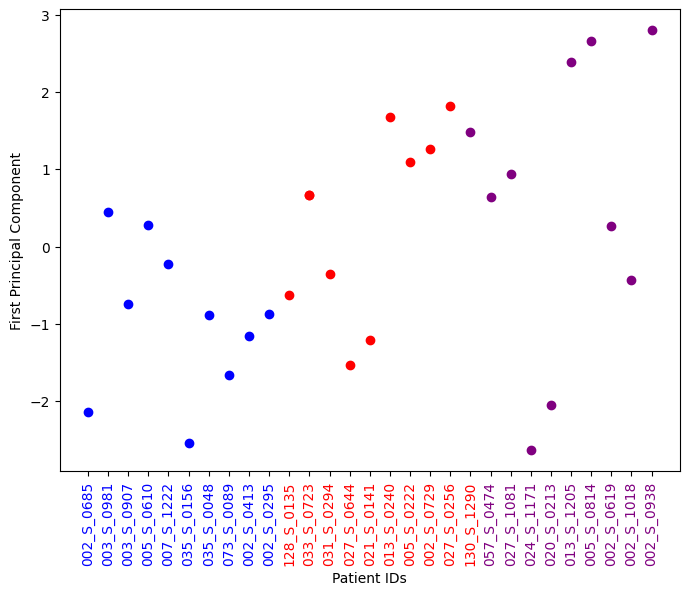

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for i in range(len(data_stand_pca)):
  plt.scatter(ordered_patient_ids[i], data_stand_pca[i, 0], color=colors_list[i])

  
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors_list):
  ticklabel.set_color(tickcolor)

plt.xticks(rotation = 90)
plt.ylabel('First Principal Component')
plt.xlabel('Patient IDs')

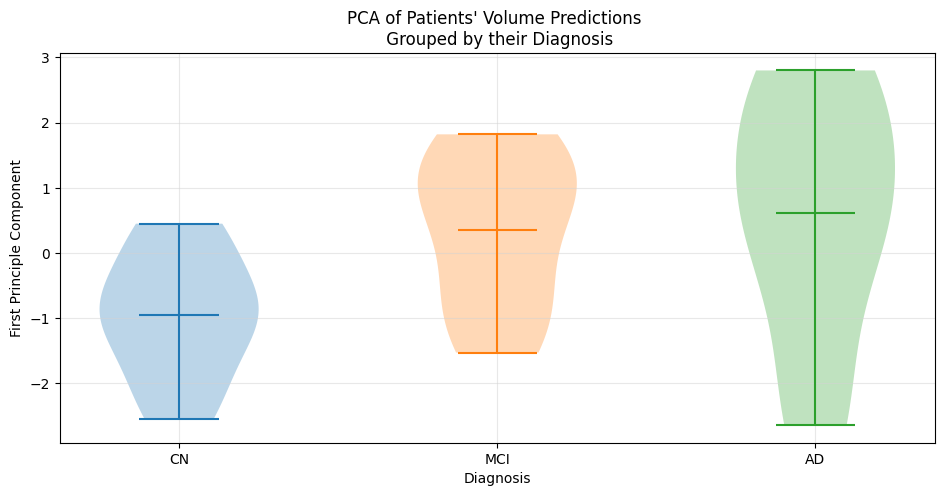

In [ ]:

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

b1 = ax1.violinplot(data_stand_pca[:10, 0], positions=[0], showmeans=True)
#median_val1 = b1['medians'][0].get_ydata()

b2 = ax1.violinplot(data_stand_pca[10:20, 0], positions=[1], showmeans=True)
#median_val2 = b2['medians'][0].get_ydata()

b3 = ax1.violinplot(data_stand_pca[20:30, 0], positions=[2], showmeans=True)
#median_val3 = b3['medians'][0].get_ydata()


ax1.set_xticks(np.arange(0,3))
ax1.set_xticklabels(['CN', 'MCI', 'AD'])
plt.xlabel('Diagnosis') 
plt.ylabel('First Principle Component')
plt.title("PCA of Patients' Volume Predictions \n Grouped by their Diagnosis")

ax1.yaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)
ax1.xaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)

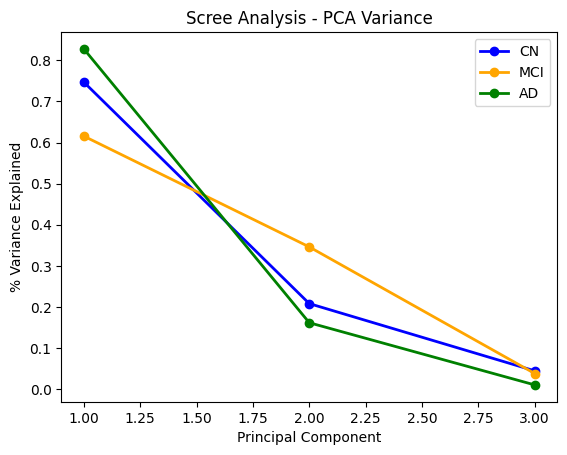

In [ ]:
num_components = np.arange(pca.n_components_) + 1
plt.plot(num_components, pca_cn.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.plot(num_components, pca_mci.explained_variance_ratio_, 'o-', linewidth=2, color='orange')
plt.plot(num_components, pca_ad.explained_variance_ratio_, 'o-', linewidth=2, color='green')
plt.title('Scree Analysis - PCA Variance')
plt.xlabel('Principal Component')
plt.ylabel('% Variance Explained')
plt.legend(['CN', 'MCI', 'AD'])
plt.show()

Training the VAE on Pre-Processed Data:

In [ ]:
#Setting the Training Hyperparameters:

#Model Dimenions:
dimen_input = trainloader.dataset.x.shape[1] #the number of features
latent_dimensions = 1                             #the size of the latent encoded vector
hidden_lay1 = 70                                  #the number of activations from that hidden layer
hidden_lay2 = 12                                  #the number of activations from that hidden layer

#Model Itself:
model_vae = Autoencoder(dimen_input, H=70, H2=12,latent_dim=1, activation= Sigmoid()).to(device) #the default z_dim=3
optimizer = optim.Adam(model_vae.parameters(), lr=0.001)
customized_loss_individual = customLoss_individual()

#Training Epochs:
epochs = 800
log_interval = 10
train_losses = []
test_losses = []

# Launch 5 simulated experiments
total_runs = 1

for run in range(total_runs):
  # Start a new run to track this script
  wandb.init(
      
      # Set the project where this run will be logged
      project="VAE_FYP_Optimization", 

      # Track hyperparameters and run metadata
      config={
      "architecture": "VAE_NN",
      })

  for epoch in range(1, epochs + 1):
      train_loss = train(epoch, trainloader, model_vae, optimizer, customized_loss_individual, train_losses, True, KL_weight=0.001)
      test_loss = test(epoch, testloader, model_vae, optimizer, customized_loss_individual, test_losses, True, KL_weight=0.001)
      
      # Log metrics from your script to W&B
      wandb.log({"train loss": train_loss})
      wandb.log({"test loss": test_loss})
      
       
  # Mark the run as finished
  wandb.finish()

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


====> Epoch: 50    Average training loss: 0.2074   Gaussian training loss: 0.2074    KL training divergence: 0.0000 
====> Epoch: 50    Average test loss: 0.1856       Gaussian test loss: 0.1855       KL test divergence: 0.0000
====> Epoch: 100    Average training loss: 0.1590   Gaussian training loss: 0.1589    KL training divergence: 0.0001 
====> Epoch: 100    Average test loss: 0.1321       Gaussian test loss: 0.1320       KL test divergence: 0.0001
====> Epoch: 150    Average training loss: 0.1235   Gaussian training loss: 0.1233    KL training divergence: 0.0001 
====> Epoch: 150    Average test loss: 0.0953       Gaussian test loss: 0.0952       KL test divergence: 0.0001
====> Epoch: 200    Average training loss: 0.0875   Gaussian training loss: 0.0873    KL training divergence: 0.0002 
====> Epoch: 200    Average test loss: 0.0580       Gaussian test loss: 0.0578       KL test divergence: 0.0001
====> Epoch: 250    Average training loss: 0.0538   Gaussian training loss: 0.0536

test loss,███▇▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train loss,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
test loss,-0.10781
train loss,-0.18651


## Hyperparameter Optimization Sweeps with WandB:

In [ ]:
def set_batch_norm(boolean_flag):
    if boolean_flag == True:
        additional_layer = nn.BatchNorm1d

    else:
        additional_layer = nn.Identity

    return additional_layer

In [ ]:
# a function that interprets the correct pytorch activation function from the name inputted as a string -> needed for the hyperparameter sweep stage
def choose_activation(name):
    if name == "Relu":
        activation = ReLU()

    elif name == "LeakyRelu":
        activation = LeakyReLU()

    elif name == "Sigmoid":
        activation = Sigmoid()

    return activation

In [ ]:
sweep_configuration = {
    'method': 'grid',
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'test_loss'
        },
    'parameters': {'lr':  {'values': [0.0001, 0.001, 0.01, 0.1]},
                   'KL_weight':  {'values': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]},
                   'batch_norm': {'values': [True, False]},
                   'activation': {'values': ["Relu", "LeakyRelu", "Sigmoid"]}
                  }
}

In [ ]:
import pprint
pprint.pprint(sweep_configuration)

{'method': 'grid',
 'metric': {'goal': 'minimize', 'name': 'test_loss'},
 'name': 'sweep',
 'parameters': {'KL_weight': {'values': [0.0001,
                                         0.0005,
                                         0.001,
                                         0.005,
                                         0.01,
                                         0.05,
                                         0.1,
                                         0.5,
                                         1]},
                'activation': {'values': ['Relu', 'LeakyRelu', 'Sigmoid']},
                'batch_norm': {'values': [True, False]},
                'lr': {'values': [0.0001, 0.001, 0.01, 0.1]}}}


In [ ]:
def main():
    wandb.init(project="VAE_FYP_Optimization1")

    
    batch_norm_layer = set_batch_norm(boolean_flag=wandb.config.batch_norm)
    activation = choose_activation(wandb.config.activation)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Autoencoder(dimen_input, H=70, H2=12,latent_dim=1, activation=activation, inbetween_layer=batch_norm_layer).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.lr) 


    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)

    for epoch in range(1, 800 + 1): #iterating for the specified number of epochs
        train_loss = train(epoch, trainloader, model, optimizer, customized_loss_individual, train_losses, True, KL_weight= wandb.config.KL_weight)
        test_loss = test(epoch, testloader, model, optimizer, customized_loss_individual, test_losses, True, KL_weight= wandb.config.KL_weight)
        #scheduler.step()

        wandb.log({"Epoch": epoch})
        wandb.log({"train loss": train_loss})
        wandb.log({"test loss": test_loss})

In [ ]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="VAE_FYP_Optimization1")

Create sweep with ID: 1kc9nqf7
Sweep URL: https://wandb.ai/mae28/VAE_FYP_Optimization1/sweeps/1kc9nqf7


In [ ]:
wandb.agent(sweep_id, function=main, count=1)

wandb: Agent Starting Run: 44mi8t6q with config:
wandb: 	KL_weight: 0.1
wandb: 	activation: Relu
wandb: 	batch_norm: False
wandb: 	lr: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


====> Epoch: 50    Average training loss: 0.2232   Gaussian training loss: 0.2232    KL training divergence: 0.0000 
====> Epoch: 50    Average test loss: 0.1927       Gaussian test loss: 0.1927       KL test divergence: 0.0000
====> Epoch: 100    Average training loss: 0.2230   Gaussian training loss: 0.2230    KL training divergence: 0.0000 
====> Epoch: 100    Average test loss: 0.1923       Gaussian test loss: 0.1923       KL test divergence: 0.0000
====> Epoch: 150    Average training loss: 0.2229   Gaussian training loss: 0.2229    KL training divergence: 0.0000 
====> Epoch: 150    Average test loss: 0.1924       Gaussian test loss: 0.1924       KL test divergence: 0.0000
====> Epoch: 200    Average training loss: 0.2229   Gaussian training loss: 0.2229    KL training divergence: 0.0000 
====> Epoch: 200    Average test loss: 0.1924       Gaussian test loss: 0.1924       KL test divergence: -0.0000
====> Epoch: 250    Average training loss: 0.2229   Gaussian training loss: 0.222

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,800
test loss,0.19232
train loss,0.22276


## Evaluating the Reconstructed Results of Trained VAE:

In [ ]:
def get_dataloader_predictions(dataloader, model, optimizer, scaler_fitted):

  real_rows_list = []
  recon_rows_list = []

  # encoding the test data using the trained model's weights
  with torch.no_grad():
      for batch_idx, batch_data in enumerate(dataloader):
          batch_data = batch_data.to(device)
          optimizer.zero_grad()

          # retransforming and scaling the real batches
          for i in range(len(batch_data)):
            real_row = np.reshape(batch_data[i].cpu(), (1,-1))
            real_row = scaler_fitted.inverse_transform(real_row.numpy())
            real_rows_list.append(np.round(real_row,0))

          recon_batch, mu, logvar, recon_logvar = model(batch_data) #inputting the test batch into the trained model

          # retransforming and scaling the reconstructed batches
          for i in range(len(recon_batch)):
            recon_row = np.reshape(recon_batch[i].cpu(), (1,-1))
            recon_row = scaler_fitted.inverse_transform(recon_row.numpy())
            recon_rows_list.append(np.round(recon_row,0))

  return  real_rows_list, recon_rows_list  

In [ ]:
#A function that computes the difference between each element pair (real, reconstructed)

def error_diff(real_rows_list, recon_rows_list):
  zip_real_recon = list(zip(real_rows_list, recon_rows_list))
  error_diff_pairs = []

  for i in range(len(zip_real_recon)):
    curr_pair = zip_real_recon[i]
    curr_real = curr_pair[0][0]
    curr_recon = curr_pair[1][0]
    new_list = []
    error_diff_pairs.append(new_list)

    for j in range(len(curr_real)):
      val_real = curr_real[j]
      val_recon = curr_recon[j]
      error_diff_pairs[i].append(abs(val_recon - val_real))

  return error_diff_pairs

In [ ]:
def make_df(real_rows_list, recon_rows_list ):
  
  # zipping real with reconstructed row for each item in the test batch
  orig_recon_zip = zip(real_rows_list, recon_rows_list )
  orig_recon = list(orig_recon_zip)

  df = pd.DataFrame(data=orig_recon, columns=['Real Row', 'Reconstructed Row'])

  return df

### Training Data - Predictions:

In [ ]:
# THE PREDICTIONS ON THE TRAINING DATA:
real_rows_list_train, recon_rows_list_train = get_dataloader_predictions(trainloader, model_vae, optimizer, scaler_fitted)
train_real_recon_df = make_df(real_rows_list_train, recon_rows_list_train)
display(train_real_recon_df)

,Real Row,Reconstructed Row
0,"[[7493.0, 4851.0, 5126.0]]","[[7522.0, 4410.0, 4437.0]]"
1,"[[7446.0, 3891.0, 4059.0]]","[[7420.0, 4335.0, 4414.0]]"
2,"[[5611.0, 3292.0, 4365.0]]","[[4821.0, 2886.0, 4018.0]]"
3,"[[7953.0, 5117.0, 4994.0]]","[[7928.0, 4726.0, 4553.0]]"
4,"[[6506.0, 4476.0, 5448.0]]","[[6517.0, 3864.0, 4352.0]]"
5,"[[6736.0, 3730.0, 3685.0]]","[[6714.0, 3945.0, 4351.0]]"
6,"[[5544.0, 3278.0, 4584.0]]","[[5540.0, 3253.0, 4119.0]]"
7,"[[6791.0, 3825.0, 3785.0]]","[[6789.0, 3878.0, 4181.0]]"
8,"[[6997.0, 4336.0, 4433.0]]","[[7557.0, 4548.0, 4598.0]]"
9,"[[5529.0, 2854.0, 3454.0]]","[[5483.0, 3224.0, 4116.0]]"


In [ ]:
# saving the dataframe of the real and reconstructions for the training data:
train_real_recon_df.to_csv('train_real_recon_df_vae.csv') 

In [ ]:
#Displaying the absolute differences in prediction for each of the tools 
train_diff_df = pd.DataFrame(error_diff(real_rows_list_train, recon_rows_list_train), columns=['FS', 'SNT', 'MAPER'])
train_diff_df.style.set_caption("Absolute Differences between Training Real and Reconstruction")
display(train_diff_df)

,FS,SNT,MAPER
0,29.0,441.0,689.0
1,26.0,444.0,355.0
2,790.0,406.0,347.0
3,25.0,391.0,441.0
4,11.0,612.0,1096.0
5,22.0,215.0,666.0
6,4.0,25.0,465.0
7,2.0,53.0,396.0
8,560.0,212.0,165.0
9,46.0,370.0,662.0


### Testing Data - Predictions:

In [ ]:
# THE PREDICTIONS ON THE TESTING DATA:
real_rows_list_test, recon_rows_list_test = get_dataloader_predictions(testloader, model_vae, optimizer, scaler_fitted)
test_real_recon_df = make_df(real_rows_list_test, recon_rows_list_test)
display(test_real_recon_df)

,Real Row,Reconstructed Row
0,"[[5867.0, 3380.0, 5028.0]]","[[5693.0, 3431.0, 4277.0]]"
1,"[[4730.0, 3035.0, 4534.0]]","[[4815.0, 2873.0, 4023.0]]"
2,"[[7962.0, 4781.0, 5450.0]]","[[8018.0, 4785.0, 4574.0]]"
3,"[[6388.0, 2978.0, 4031.0]]","[[6602.0, 3821.0, 4269.0]]"
4,"[[7223.0, 4287.0, 4796.0]]","[[7162.0, 4127.0, 4316.0]]"
5,"[[7429.0, 4031.0, 4632.0]]","[[7422.0, 4314.0, 4379.0]]"


In [ ]:
# saving the dataframe of the real and reconstructions for the testing data:
train_real_recon_df.to_csv('test_real_recon_df_vae.csv') 

In [ ]:
#Displaying the absolute differences in prediction for each of the tools 

train_diff_df = pd.DataFrame(error_diff(real_rows_list_test, recon_rows_list_test), columns=['FS', 'SNT', 'MAPER'])
train_diff_df.style.set_caption("Absolute Differences between Training Real and Reconstruction")
display(train_diff_df)

,FS,SNT,MAPER
0,174.0,51.0,751.0
1,85.0,162.0,511.0
2,56.0,4.0,876.0
3,214.0,843.0,238.0
4,61.0,160.0,480.0
5,7.0,283.0,253.0


# Uncertainty in the Latent Dimensions: 

Steps:
- convert the logvariances to std 
- take row-wise sum of the std in the latent dimensions 
- plot the sum of the latent uncertainties/std against the disease labels 
- make sure only one example of each patient is shown - use patient ID

In [ ]:
# encoding all rows simulating a patient at a time obtaining the compressed latent vectors for each

data_full_arr  = np.array(data_standardized)
data_full_arr  = data_full_arr.reshape(-1, data_full_arr.shape[1]).astype('float32')

dataset_full_tensor = torch.from_numpy(data_full_arr)

rows = dataset_full_tensor.to(device)
optimizer.zero_grad()
mu_encod, logvar_encod = model_vae.encode(rows) #probably want to use the individual log_variances here?

In [ ]:
print(logvar_encod)

tensor([[-6.7951],
        [-7.2926],
        [-7.1945],
        [-7.2035],
        [-7.1033],
        [-6.8996],
        [-7.1905],
        [-7.0238],
        [-6.7567],
        [-6.6727],
        [-7.0931],
        [-7.2966],
        [-7.1194],
        [-6.5223],
        [-6.7486],
        [-6.9231],
        [-6.9489],
        [-6.7532],
        [-7.2966],
        [-7.1647],
        [-7.1689],
        [-6.6755],
        [-6.7587],
        [-6.4713],
        [-6.7843],
        [-7.1831],
        [-7.0747],
        [-6.3602],
        [-6.6947],
        [-7.0894]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
logvar_encod_reshaped = logvar_encod.cpu().detach().numpy() #converting from log variance to variance to std. 
latent_rows_std =  [[(np.exp(logvar/2)) for logvar in logvar_row] for logvar_row in logvar_encod_reshaped]
df_uncertainties_latent_dim = pd.DataFrame(latent_rows_std)


In [ ]:
df_uncertainties_latent_dim_ids = df_uncertainties_latent_dim.set_index(df_hippo_volumes_data.columns)
df_merged_uncertainty_disease_label = pd.concat([df_uncertainties_latent_dim_ids , pd.DataFrame(df_hippo_volumes_data.loc['Diagnosis'])], axis=1)
df_merged_uncertainty_disease_label = df_merged_uncertainty_disease_label.rename(columns={0: "Latent Uncertainty"})
df_merged_uncertainty_disease_label.head()

,Latent Uncertainty,Diagnosis
002_S_0685,0.033455,CN
003_S_0981,0.026087,CN
003_S_0907,0.027399,CN
005_S_0610,0.027276,CN
007_S_1222,0.028678,CN


In [ ]:
df_cn_patients_uncertainty = df_merged_uncertainty_disease_label.iloc[:10]
cn_patients_uncertainty = list(df_cn_patients_uncertainty['Latent Uncertainty'])

df_mci_patients_uncertainty = df_merged_uncertainty_disease_label.iloc[10:20]
mci_patients_uncertainty = list(df_mci_patients_uncertainty['Latent Uncertainty'])

df_ad_patients_uncertainty = df_merged_uncertainty_disease_label.iloc[20:30]
ad_patients_uncertainty = list(df_ad_patients_uncertainty['Latent Uncertainty'])
df_ad_patients_uncertainty.head()
print(ad_patients_uncertainty)

[0.027751536438169543, 0.03551734948512802, 0.034069838266377765, 0.03933510494542557, 0.033635505728577944, 0.027555372834947685, 0.02909091260038493, 0.04158125041031351, 0.03517775701636735, 0.028876791365266368]


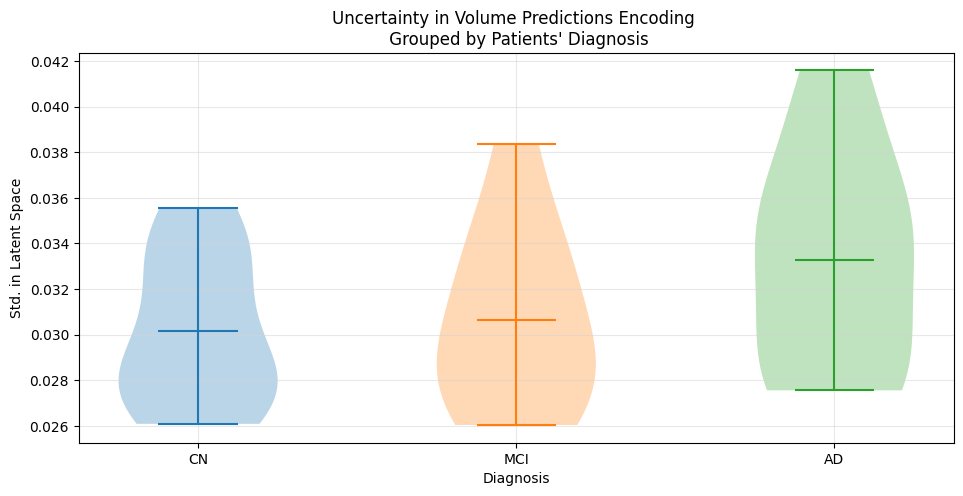

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

b1 = ax1.violinplot(cn_patients_uncertainty, positions=[0], showmeans=True)

b2 = ax1.violinplot(mci_patients_uncertainty, positions=[1], showmeans=True)

b3 = ax1.violinplot(ad_patients_uncertainty , positions=[2], showmeans=True)


ax1.set_xticks(np.arange(0,3))
ax1.set_xticklabels(['CN', 'MCI', 'AD'])
plt.xlabel('Diagnosis') 
plt.ylabel('Std. in Latent Space')
plt.title("Uncertainty in Volume Predictions Encoding \n Grouped by Patients' Diagnosis")

ax1.yaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)
ax1.xaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)

In [ ]:
patient_ids = df_hippo_volumes_data.columns
disease_labels = df_hippo_volumes_data.loc['Diagnosis']

In [ ]:
def get_average_stds(num_runs, num_epochs, data_standardized, disease_labels):

  list_stds_each_run = []
  df_list_std = pd.DataFrame(disease_labels)

  # preparing the data for encoding/testing
  data_full_arr  = np.array(data_standardized)
  data_full_arr  = data_full_arr.reshape(-1, data_full_arr.shape[1]).astype('float32')
  dataset_full_tensor = torch.from_numpy(data_full_arr)
  rows = dataset_full_tensor.to(device)

  for i in range(num_runs):
    print('Run {}:'.format(i))
    train_losses = []
    test_losses = []
    model_vae_avg = Autoencoder(dimen_input, H=70, H2=12,latent_dim=1, activation= Sigmoid()).to(device) 
    optimizer = optim.Adam(model_vae.parameters(), lr=0.001)
    customized_loss_individual = customLoss_individual()

    for epoch in range(1, num_epochs + 1):
      train(epoch, trainloader, model_vae, optimizer, customized_loss_individual, train_losses, KL_weight=0.001)
      test(epoch, testloader, model_vae, optimizer, customized_loss_individual, test_losses, KL_weight=0.001)

    optimizer.zero_grad()
    mu_encod, logvar_encod = model_vae_avg.encode(rows) 

    logvar_encod_reshaped = logvar_encod.cpu().detach().numpy() #converting from log variance to variance to std. 

    latent_rows_std =  [[(np.exp(logvar/2)) for logvar in logvar_row] for logvar_row in logvar_encod_reshaped]
    latent_rows_std = [val[0] for val in latent_rows_std] #extract the numerical values from the nested array
    #latent_rows_std_rounded =  [np.round(std, 2) for std in decoded_rows_std]

    list_stds_each_run.append(latent_rows_std)
    df_list_std['Run {}'.format(i)] = latent_rows_std

  return list_stds_each_run, df_list_std


In [ ]:
list_stds_each_run, df_list_std = get_average_stds(3, 500, data_standardized, disease_labels)
df_list_std['mean'] = df_list_std.mean(axis=1)
display(df_list_std)

Run 0:
====> Epoch: 50    Average training loss: -0.7022   Gaussian training loss: -0.7029    KL training divergence: 0.0007 
====> Epoch: 50    Average test loss: 8.4798       Gaussian test loss: 8.4793       KL test divergence: 0.0005
====> Epoch: 100    Average training loss: -0.7782   Gaussian training loss: -0.7788    KL training divergence: 0.0007 
====> Epoch: 100    Average test loss: 12.7344       Gaussian test loss: 12.7339       KL test divergence: 0.0005
====> Epoch: 150    Average training loss: -0.7261   Gaussian training loss: -0.7268    KL training divergence: 0.0007 
====> Epoch: 150    Average test loss: 6.3840       Gaussian test loss: 6.3834       KL test divergence: 0.0005
====> Epoch: 200    Average training loss: -0.7586   Gaussian training loss: -0.7592    KL training divergence: 0.0007 
====> Epoch: 200    Average test loss: 6.3848       Gaussian test loss: 6.3843       KL test divergence: 0.0005
====> Epoch: 250    Average training loss: -0.7768   Gaussian tra

<ipython-input-174-1fc06b885eb3>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_list_std['mean'] = df_list_std.mean(axis=1)


,Diagnosis,Run 0,Run 1,Run 2,mean
002_S_0685,CN,1.132488,1.605046,1.143606,1.293713
003_S_0981,CN,1.108178,1.598596,1.154297,1.287024
003_S_0907,CN,1.110198,1.593380,1.151484,1.285021
005_S_0610,CN,1.131934,1.586578,1.140420,1.286311
007_S_1222,CN,1.112402,1.613622,1.165104,1.297043
035_S_0156,CN,1.109778,1.595252,1.148690,1.284574
035_S_0048,CN,1.099250,1.606132,1.163111,1.289497
073_S_0089,CN,1.098702,1.602883,1.167758,1.289781
002_S_0413,CN,1.140580,1.616583,1.154557,1.303907
002_S_0295,CN,1.144310,1.628783,1.162835,1.311976


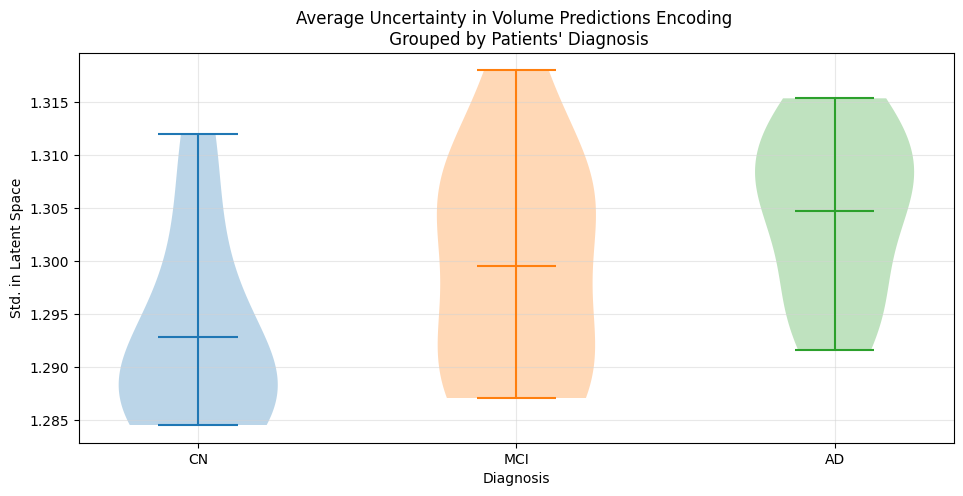

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

b1 = ax1.violinplot(df_list_std['mean'][:10], positions=[0], showmeans=True)

b2 = ax1.violinplot(df_list_std['mean'][10:20], positions=[1], showmeans=True)

b3 = ax1.violinplot(df_list_std['mean'][20:30] , positions=[2], showmeans=True)


ax1.set_xticks(np.arange(0,3))
ax1.set_xticklabels(['CN', 'MCI', 'AD'])
plt.xlabel('Diagnosis') 
plt.ylabel('Std. in Latent Space')
plt.title("Average Uncertainty in Volume Predictions Encoding \n Grouped by Patients' Diagnosis")

ax1.yaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)
ax1.xaxis.grid(True, linestyle='-', color='lightgrey',
               alpha=0.5)

Storing and Exporting Encoded Data

In [ ]:
# saving the dataframe of the individual runs and mean latent standard deviation/uncertainty
df_list_std.to_csv('df_latent_uncertainties_average.csv') 

End of VAE Encoding Stage. 